### Importing Libraries

In [58]:
import requests
import json
from pandas.io.json import json_normalize
import pandas as pd

#datavisualizations
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

#requests_cache to cache API call data
import requests_cache 
import time
from IPython.core.display import clear_output
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# keeping data from API calls into cache
requests_cache.install_cache()

### API Calls

While Loop over api.spacexdata (great API !) - over launch pages

Append list with API call results, to then make a DataFrame out of it
All calls cached locally with requests_cache : limit amount of calls needed and ease on the API server

In [5]:
page = 1
final_page = 110 #final page for while loop

responses_list = []

#loop over page with url launches/page
while page < final_page:
    print('The rocket is on the launch pad - API call ignition')
    print(f'SpaceX API call - requesting page {page}/{page}')
    
    # clear the output of each print to make things neater
    clear_output(wait = True)
    
    payload = {'limit':500,
    'page':page}
    url = f'https://api.spacexdata.com/v3/launches/{page}'
    
    response = requests.get(url)
    
    #back stop if error = stop looping
    if response.status_code != 200:
        print('limit page result reached on page number',page,response.text, '- end of API call')
        break
    
    #if it's not a cached result, sleep
    if not getattr(response, 'from_cache', False):
        time.sleep(0.35)
    
    #append response list
    responses_list.append(response)
    
    #increment page number
    page += 1
    
    print("Requested page {}/{}".format(page, page), 'SpaceX API call completed')

limit page result reached on page number 106 {"error":"Not Found"} - end of API call


###### testing API call on 1st launch

In [6]:
url = 'https://api.spacexdata.com/v3/launches/'

result = requests.get(f'https://api.spacexdata.com/v3/launches/1')

print(json.dumps(result.json(), indent=4))

{
    "flight_number": 1,
    "mission_name": "FalconSat",
    "mission_id": [],
    "upcoming": false,
    "launch_year": "2006",
    "launch_date_unix": 1143239400,
    "launch_date_utc": "2006-03-24T22:30:00.000Z",
    "launch_date_local": "2006-03-25T10:30:00+12:00",
    "is_tentative": false,
    "tentative_max_precision": "hour",
    "tbd": false,
    "launch_window": 0,
    "rocket": {
        "rocket_id": "falcon1",
        "rocket_name": "Falcon 1",
        "rocket_type": "Merlin A",
        "first_stage": {
            "cores": [
                {
                    "core_serial": "Merlin1A",
                    "flight": 1,
                    "block": null,
                    "gridfins": false,
                    "legs": false,
                    "reused": false,
                    "land_success": null,
                    "landing_intent": false,
                    "landing_type": null,
                    "landing_vehicle": null
                }
            ]
     

dict of dictionaries

Nested dictionaries & nested lists among columns for 1st stage & 2nd stage of the rocket

- Series 'rocket' encompass key data : first stage & second stage payload data
looping with list to merge data to main df

In [7]:
#dummy df of JSON call & normalize JSON to picture final df result
r0 = responses_list[0]
r0_json = json_normalize(r0.json())
df1 = pd.DataFrame(r0_json)
df1.head()

,flight_number,mission_name,mission_id,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,ships,launch_success,details,static_fire_date_utc,static_fire_date_unix,crew,rocket.rocket_id,rocket.rocket_name,rocket.rocket_type,rocket.first_stage.cores,rocket.second_stage.block,rocket.second_stage.payloads,rocket.fairings.reused,rocket.fairings.recovery_attempt,rocket.fairings.recovered,rocket.fairings.ship,telemetry.flight_club,launch_site.site_id,launch_site.site_name,launch_site.site_name_long,launch_failure_details.time,launch_failure_details.altitude,launch_failure_details.reason,links.mission_patch,links.mission_patch_small,links.reddit_campaign,links.reddit_launch,links.reddit_recovery,links.reddit_media,links.presskit,links.article_link,links.wikipedia,links.video_link,links.youtube_id,links.flickr_images,timeline.webcast_liftoff
0,1,FalconSat,[],False,2006,1143239400,2006-03-24T22:30:00.000Z,2006-03-25T10:30:00+12:00,False,hour,False,0,[],False,Engine failure at 33 seconds and loss of vehicle,2006-03-17T00:00:00.000Z,1142553600,None,falcon1,Falcon 1,Merlin A,"[{'core_serial': 'Merlin1A', 'flight': 1, 'blo...",1,"[{'payload_id': 'FalconSAT-2', 'norad_id': [],...",False,False,False,None,None,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,33,None,merlin engine failure,https://images2.imgbox.com/40/e3/GypSkayF_o.png,https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,None,None,None,None,None,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,[],54


In [8]:
df1.columns

Index(['flight_number', 'mission_name', 'mission_id', 'upcoming',
       'launch_year', 'launch_date_unix', 'launch_date_utc',
       'launch_date_local', 'is_tentative', 'tentative_max_precision', 'tbd',
       'launch_window', 'ships', 'launch_success', 'details',
       'static_fire_date_utc', 'static_fire_date_unix', 'crew',
       'rocket.rocket_id', 'rocket.rocket_name', 'rocket.rocket_type',
       'rocket.first_stage.cores', 'rocket.second_stage.block',
       'rocket.second_stage.payloads', 'rocket.fairings.reused',
       'rocket.fairings.recovery_attempt', 'rocket.fairings.recovered',
       'rocket.fairings.ship', 'telemetry.flight_club', 'launch_site.site_id',
       'launch_site.site_name', 'launch_site.site_name_long',
       'launch_failure_details.time', 'launch_failure_details.altitude',
       'launch_failure_details.reason', 'links.mission_patch',
       'links.mission_patch_small', 'links.reddit_campaign',
       'links.reddit_launch', 'links.reddit_recovery', 'lin

### Listing variables

**Important variables to keep**

- 'launch_year' : deprecated 
- 'launch_date_unix' : 
- 'launch_date_utc', :
- - 'crew', : 
- 'ships' : 
- 'launch_success' : True when success
- 'details', : 
- 'launch_site.site_id', : 
- 'launch_site.site_name' : 
- 'launch_site.site_name_long', : 
- 'launch_failure_details.time' : 
- 'launch_failure_details.altitude', : 
- 'launch_failure_details.reason' : 

**ID related**
- flight_number : 
- mission_name : 
- mission_id : 

**Launch related**
- launch_year : deprecated 
- launch_date_unix : 
- launch_date_utc :
- - crew : 
- ships : 
- launch_success : True when success
- details : 
- launch_site.site_id : 
- launch_site.site_name : 
- launch_site.site_name_long : 
- launch_failure_details.time : 
- launch_failure_details.altitude : 
- launch_failure_details.reason : 

**Rocket related**
- rocket.rocket_id : 
- rocket.rocket_name : 
- rocket.rocket_type :
- rocket.second_stage.payloads : 
- rocket.fairings.reused : 
- rocket.fairings.recovery_attempt : 
- rocket.fairings.recovered : 

**Useless**
- ditching all links columns = only article & PNG links
- upcoming' : Set as true until the moment of launch

### Flatenning data from API call

- Exploring API data through different nested dictionaries
- creating datafarme with only nested data unfold in columns
- df with 600 columns ! many NaNs, keeping only relevant columns

Function to flatten out JSON call of different nested levels

In [9]:
def flatten_json(y):
    out = {}
    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x
    flatten(y)
    return out

In [10]:
#GOOD FLATTENING !

In [11]:
#empty list to append all API calls
temp_frame = [] 
for i in range(len(responses_list)):
    r = responses_list[i]    
    flat = flatten_json(r.json())
    temp_frame.append(flat)
    flatten_df = pd.DataFrame(temp_frame)
flatten_df

,flight_number,mission_name,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_land_success,rocket_first_stage_cores_0_landing_intent,rocket_first_stage_cores_0_landing_type,rocket_first_stage_cores_0_landing_vehicle,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_longitude,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_lifespan_years,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,rocket_fairings_reused,rocket_fairings_recovery_attempt,rocket_fairings_recovered,rocket_fairings_ship,telemetry_flight_club,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,launch_failure_details_time,launch_failure_details_altitude,launch_failure_details_reason,links_mission_patch,links_mission_patch_small,links_reddit_campaign,links_reddit_launch,links_reddit_recovery,links_reddit_media,links_presskit,links_article_link,links_wikipedia,links_video_link,links_youtube_id,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,crew,rocket_second_stage_payloads_1_payload_id,rocket_second_stage_payloads_1_reused,rocket_second_stage_payloads_1_customers_0,rocket_second_stage_payloads_1_nationality,rocket_second_stage_payloads_1_manufacturer,rocket_second_stage_payloads_1_payload_type,rocket_second_stage_payloads_1_payload_mass_kg,rocket_second_stage_payloads_1_payload_mass_lbs,rocket_second_stage_payloads_1_orbit,rocket_second_stage_payloads_1_orbit_params_reference_system,rocket_second_stage_payloads_1_orbit_params_regime,rocket_second_stage_payloads_1_orbit_params_longitude,rocket_second_stage_payloads_1_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_1_orbit_params_eccentricity,rocket_second_stage_payloads_1_orbit_params_periapsis_km,rocket_second_stage_payloads_1_orbit_params_apoapsis_km,rocket_second_stage_payloads_1_orbit_params_inclination_deg,rocket_second_stage_payloads_1_orbit_params_period_min,rocket_second_stage_payloads_1_orbit_params_lifespan_years,rocket_second_stage_payloads_1_orbit_params_epoch,rocket_second_stage_payloads_1_orbit_params_mean_motion,rocket_second_stage_payloads_1_orbit_params_raan,rocket_second_stage_payloads_1_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_1_orbit_params_mean_anomaly,rocket_second_stage_payloads_0_norad_id_0,mission_id_0,rocket_fairings,timeline_go_for_prop_loading,timeline_rp1_loading,timeline_stage1_lox_loading,timeline_stage2_lox_loading,timeline_engine_chill,timeline_prelaunch_checks,timeline_propellant_pressurization,timeline_go_for_launch,timeline_ignition,timeline_liftoff,timeline_maxq,

In [12]:
flatten_df.tail(10)

,flight_number,mission_name,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_land_success,rocket_first_stage_cores_0_landing_intent,rocket_first_stage_cores_0_landing_type,rocket_first_stage_cores_0_landing_vehicle,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_longitude,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_lifespan_years,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,rocket_fairings_reused,rocket_fairings_recovery_attempt,rocket_fairings_recovered,rocket_fairings_ship,telemetry_flight_club,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,launch_failure_details_time,launch_failure_details_altitude,launch_failure_details_reason,links_mission_patch,links_mission_patch_small,links_reddit_campaign,links_reddit_launch,links_reddit_recovery,links_reddit_media,links_presskit,links_article_link,links_wikipedia,links_video_link,links_youtube_id,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,crew,rocket_second_stage_payloads_1_payload_id,rocket_second_stage_payloads_1_reused,rocket_second_stage_payloads_1_customers_0,rocket_second_stage_payloads_1_nationality,rocket_second_stage_payloads_1_manufacturer,rocket_second_stage_payloads_1_payload_type,rocket_second_stage_payloads_1_payload_mass_kg,rocket_second_stage_payloads_1_payload_mass_lbs,rocket_second_stage_payloads_1_orbit,rocket_second_stage_payloads_1_orbit_params_reference_system,rocket_second_stage_payloads_1_orbit_params_regime,rocket_second_stage_payloads_1_orbit_params_longitude,rocket_second_stage_payloads_1_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_1_orbit_params_eccentricity,rocket_second_stage_payloads_1_orbit_params_periapsis_km,rocket_second_stage_payloads_1_orbit_params_apoapsis_km,rocket_second_stage_payloads_1_orbit_params_inclination_deg,rocket_second_stage_payloads_1_orbit_params_period_min,rocket_second_stage_payloads_1_orbit_params_lifespan_years,rocket_second_stage_payloads_1_orbit_params_epoch,rocket_second_stage_payloads_1_orbit_params_mean_motion,rocket_second_stage_payloads_1_orbit_params_raan,rocket_second_stage_payloads_1_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_1_orbit_params_mean_anomaly,rocket_second_stage_payloads_0_norad_id_0,mission_id_0,rocket_fairings,timeline_go_for_prop_loading,timeline_rp1_loading,timeline_stage1_lox_loading,timeline_stage2_lox_loading,timeline_engine_chill,timeline_prelaunch_checks,timeline_propellant_pressurization,timeline_go_for_launch,timeline_ignition,timeline_liftoff,timeline_maxq,

In [13]:
flatten_df.columns

Index(['flight_number', 'mission_name', 'upcoming', 'launch_year',
       'launch_date_unix', 'launch_date_utc', 'launch_date_local',
       'is_tentative', 'tentative_max_precision', 'tbd',
       ...
       'rocket_second_stage_payloads_15_orbit_params_mean_anomaly',
       'timeline_seco-3', 'timeline_seco-4', 'last_date_update',
       'last_ll_launch_date', 'last_ll_update', 'last_wiki_launch_date',
       'last_wiki_revision', 'last_wiki_update', 'launch_date_source'],
      dtype='object', length=615)

In [14]:
# flatten_df.drop(columns=links,axis=1)

In [15]:
#listing all empty columns
percent_missing = flatten_df.isnull().sum() / len(flatten_df) * 100

percent_missing.sort_values().head(60)

flight_number                                                     0.000000
launch_site_site_name_long                                        0.000000
rocket_second_stage_payloads_0_orbit                              0.000000
rocket_second_stage_payloads_0_payload_type                       0.000000
rocket_second_stage_payloads_0_nationality                        0.000000
rocket_second_stage_payloads_0_customers_0                        0.000000
rocket_second_stage_payloads_0_reused                             0.000000
rocket_second_stage_payloads_0_payload_id                         0.000000
launch_site_site_name                                             0.000000
rocket_rocket_type                                                0.000000
rocket_rocket_name                                                0.000000
launch_site_site_id                                               0.000000
launch_date_unix                                                  0.000000
tbd                      

In [16]:
#dropping all columns that starts with 'links'
flatten_df[flatten_df.columns.drop(list(flatten_df.filter(regex='links')))]

,flight_number,mission_name,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_land_success,rocket_first_stage_cores_0_landing_intent,rocket_first_stage_cores_0_landing_type,rocket_first_stage_cores_0_landing_vehicle,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_longitude,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_lifespan_years,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,rocket_fairings_reused,rocket_fairings_recovery_attempt,rocket_fairings_recovered,rocket_fairings_ship,telemetry_flight_club,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,launch_failure_details_time,launch_failure_details_altitude,launch_failure_details_reason,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,crew,rocket_second_stage_payloads_1_payload_id,rocket_second_stage_payloads_1_reused,rocket_second_stage_payloads_1_customers_0,rocket_second_stage_payloads_1_nationality,rocket_second_stage_payloads_1_manufacturer,rocket_second_stage_payloads_1_payload_type,rocket_second_stage_payloads_1_payload_mass_kg,rocket_second_stage_payloads_1_payload_mass_lbs,rocket_second_stage_payloads_1_orbit,rocket_second_stage_payloads_1_orbit_params_reference_system,rocket_second_stage_payloads_1_orbit_params_regime,rocket_second_stage_payloads_1_orbit_params_longitude,rocket_second_stage_payloads_1_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_1_orbit_params_eccentricity,rocket_second_stage_payloads_1_orbit_params_periapsis_km,rocket_second_stage_payloads_1_orbit_params_apoapsis_km,rocket_second_stage_payloads_1_orbit_params_inclination_deg,rocket_second_stage_payloads_1_orbit_params_period_min,rocket_second_stage_payloads_1_orbit_params_lifespan_years,rocket_second_stage_payloads_1_orbit_params_epoch,rocket_second_stage_payloads_1_orbit_params_mean_motion,rocket_second_stage_payloads_1_orbit_params_raan,rocket_second_stage_payloads_1_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_1_orbit_params_mean_anomaly,rocket_second_stage_payloads_0_norad_id_0,mission_id_0,rocket_fairings,timeline_go_for_prop_loading,timeline_rp1_loading,timeline_stage1_lox_loading,timeline_stage2_lox_loading,timeline_engine_chill,timeline_prelaunch_checks,timeline_propellant_pressurization,timeline_go_for_launch,timeline_ignition,timeline_liftoff,timeline_maxq,timeline_meco,timeline_stage_sep,timeline_second_stage_ignition,timeline_seco-1,rocket_second_stage_payloads_0_cap_serial,ships_0,timeline_dragon_separation,rocket_second_stage_payloads_0_mass_returned_kg,rocket_s

Keeping only columns with over 70% values

In [17]:
#Boolean indexing all columns with less than 30% missing data
percent_missing < 30

flight_number             True
mission_name              True
upcoming                  True
launch_year               True
launch_date_unix          True
                         ...  
last_ll_update           False
last_wiki_launch_date    False
last_wiki_revision       False
last_wiki_update         False
launch_date_source       False
Length: 615, dtype: bool

In [18]:
spacex_data = flatten_df[flatten_df.columns[percent_missing < 30]]
spacex_data

,flight_number,mission_name,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_landing_intent,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,links_mission_patch,links_mission_patch_small,links_reddit_launch,links_presskit,links_article_link,links_wikipedia,links_video_link,links_youtube_id,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,rocket_second_stage_payloads_0_norad_id_0,timeline_go_for_prop_loading,timeline_stage1_lox_loading,timeline_stage2_lox_loading,timeline_engine_chill,timeline_prelaunch_checks,timeline_propellant_pressurization,timeline_go_for_launch,timeline_ignition,timeline_liftoff,timeline_second_stage_ignition,links_flickr_images_0,links_flickr_images_1,links_flickr_images_2,links_flickr_images_3
0,1,FalconSat,False,2006,1143239400,2006-03-24T22:30:00.000Z,2006-03-25T10:30:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin A,Merlin1A,1.0,NaN,False,False,False,False,1.0,FalconSAT-2,False,DARPA,United States,SSTL,Satellite,20.0,43.000,LEO,geocentric,low-earth,NaN,NaN,400.000,500.000,39.0000,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,https://images2.imgbox.com/40/e3/GypSkayF_o.png,https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,None,None,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,Engine failure at 33 seconds and loss of vehicle,2006-03-17T00:00:00.000Z,1.142554e+09,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,DemoSat,False,2007,1174439400,2007-03-21T01:10:00.000Z,2007-03-21T13:10:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin A,Merlin2A,1.0,NaN,False,False,False,False,1.0,DemoSAT,False,DARPA,United States,SpaceX,Satellite,NaN,NaN,LEO,geocentric,low-earth,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,https://images2.imgbox.com/be/e7/iNqsqVYM_o.png,https://images2.imgbox.com/4f/e3/I0lkuJ2e_o.png,None,None,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,Successful first stage burn and transition to ...,None,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Trailblazer,False,2008,1217648040,2008-08-02T03:34:00.000Z,2008-08-02T15:34:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin C,Merlin1C,1.0,NaN,

In [19]:
spacex_data = spacex_data[spacex_data.columns.drop(list(spacex_data.filter(regex='links')))]

In [20]:
spacex_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 63 columns):
flight_number                                                     105 non-null int64
mission_name                                                      105 non-null object
upcoming                                                          105 non-null bool
launch_year                                                       105 non-null object
launch_date_unix                                                  105 non-null int64
launch_date_utc                                                   105 non-null object
launch_date_local                                                 105 non-null object
is_tentative                                                      105 non-null bool
tentative_max_precision                                           105 non-null object
tbd                                                               105 non-null bool
launch_window                              

### Data wrangling

Two datetime columns : UTC & local_time.
- keeping only UTC column : easiest to convert 
- splitting date & time in two different columns

In [21]:
spacex_data['launch_date_utc'] = pd.to_datetime(spacex_data['launch_date_utc'])
spacex_data['launch_date_utc'] = spacex_data['launch_date_utc'].dt.tz_convert('US/Eastern')
spacex_data['launch_date_utc']

0     2006-03-24 17:30:00-05:00
1     2007-03-20 21:10:00-04:00
2     2008-08-01 23:34:00-04:00
3     2008-09-28 19:15:00-04:00
4     2009-07-12 23:35:00-04:00
                 ...           
100   2019-12-31 19:00:00-05:00
101   2020-08-29 20:00:00-04:00
102   2020-06-30 20:00:00-04:00
103   2020-06-30 20:00:00-04:00
104   2020-10-19 20:00:00-04:00
Name: launch_date_utc, Length: 105, dtype: datetime64[ns, US/Eastern]

In [22]:
spacex_data['launch_date'] = spacex_data['launch_date_utc'].dt.to_period('D')
spacex_data['launch_year'] = spacex_data['launch_date_utc'].dt.year
spacex_data['launch_time'] = spacex_data['launch_date_utc'].dt.time

In [23]:
spacex_data

,flight_number,mission_name,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_landing_intent,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,rocket_second_stage_payloads_0_norad_id_0,timeline_go_for_prop_loading,timeline_stage1_lox_loading,timeline_stage2_lox_loading,timeline_engine_chill,timeline_prelaunch_checks,timeline_propellant_pressurization,timeline_go_for_launch,timeline_ignition,timeline_liftoff,timeline_second_stage_ignition,launch_date,launch_time
0,1,FalconSat,False,2006,1143239400,2006-03-24 17:30:00-05:00,2006-03-25T10:30:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin A,Merlin1A,1.0,NaN,False,False,False,False,1.0,FalconSAT-2,False,DARPA,United States,SSTL,Satellite,20.0,43.000,LEO,geocentric,low-earth,NaN,NaN,400.000,500.000,39.0000,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,Engine failure at 33 seconds and loss of vehicle,2006-03-17T00:00:00.000Z,1.142554e+09,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-03-24,17:30:00
1,2,DemoSat,False,2007,1174439400,2007-03-20 21:10:00-04:00,2007-03-21T13:10:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin A,Merlin2A,1.0,NaN,False,False,False,False,1.0,DemoSAT,False,DARPA,United States,SpaceX,Satellite,NaN,NaN,LEO,geocentric,low-earth,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,Successful first stage burn and transition to ...,None,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-03-20,21:10:00
2,3,Trailblazer,False,2008,1217648040,2008-08-01 23:34:00-04:00,2008-08-02T15:34:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin C,Merlin1C,1.0,NaN,False,False,False,False,1.0,Trailblazer,False,NASA,United States,Space Dev,Satellite,NaN,NaN,LEO,geocentric,low-earth,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,Residual stage 1 thrust led to collision betwe...,None,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-08-01,23:34:00
3,4,RatSat,False,2008,1222643700,2008-09-28 19:15:00-04:00,2008-09-28T11:15:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin C,Merlin2C,1.0,NaN,False,False,False,False,1.0,RatSat,False,SpaceX,United States,SpaceX,Satellite,165.0,363.000,LEO,geocentric,low-earth,6992.251,0.001269,605.243,622.989,9.3467,96.980,2020-05-26T16:23:34.000Z,14.8

In [24]:
spacex_data['rocket_second_stage_payloads_0_payload_mass_kg'].head(50)

0       20.0
1        NaN
2        NaN
3      165.0
4      200.0
5        NaN
6        NaN
7      525.0
8      400.0
9      677.0
10     500.0
11    3170.0
12    3325.0
13    2296.0
14    1316.0
15    4535.0
16    4428.0
17    2216.0
18    2395.0
19     570.0
20    1954.0
21    1898.0
22    4707.0
23    2477.0
24    2034.0
25     553.0
26    5271.0
27    3136.0
28    4696.0
29    3100.0
30    1800.0
31    2257.0
32    4600.0
33    5500.0
34    9600.0
35    2490.0
36    5600.0
37    5300.0
38       NaN
39    6070.0
40    2708.0
41    3669.0
42    9600.0
43    6761.0
44    2910.0
45     475.0
46    4990.0
47    9600.0
48    5200.0
49    3700.0
Name: rocket_second_stage_payloads_0_payload_mass_kg, dtype: float64

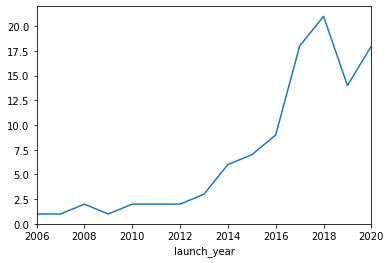

In [25]:
space_date = spacex_data.groupby('launch_year').agg({'flight_number':'count','rocket_second_stage_payloads_0_payload_mass_kg':'mean'})
space_date['flight_number'].plot()

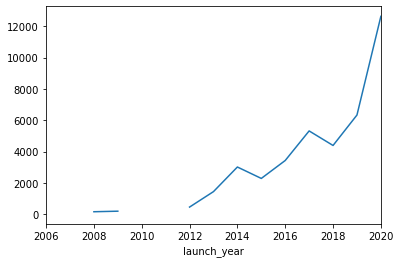

In [26]:
space_date['rocket_second_stage_payloads_0_payload_mass_kg'].plot()

In [27]:
# spacex_data['launch_date'] = pd.to_datetime(spacex_data['launch_date_local'], utc=False)
# # format='%Y-%m-%d')
# # # spacex_data['launch_date'].dt.strftime('%Y-%m-%d')
# # spacex_data['launch_date']

In [28]:
spacex_data['rocket_second_stage_payloads_0_payload_mass_kg'].describe()

count       92.000000
mean      5182.386413
std       4431.759760
min         20.000000
25%       2213.250000
50%       3940.000000
75%       6565.250000
max      15600.000000
Name: rocket_second_stage_payloads_0_payload_mass_kg, dtype: float64

In [29]:
spacex_data[spacex_data['rocket_second_stage_payloads_0_payload_mass_kg'] ==  15600]

,flight_number,mission_name,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_landing_intent,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,rocket_second_stage_payloads_0_norad_id_0,timeline_go_for_prop_loading,timeline_stage1_lox_loading,timeline_stage2_lox_loading,timeline_engine_chill,timeline_prelaunch_checks,timeline_propellant_pressurization,timeline_go_for_launch,timeline_ignition,timeline_liftoff,timeline_second_stage_ignition,launch_date,launch_time
83,84,Starlink 1,False,2019,1573484160,2019-11-11 09:56:00-05:00,2019-11-11T09:56:00-05:00,False,hour,False,0.0,falcon9,Falcon 9,FT,B1048,4.0,5.0,True,True,True,True,5.0,Starlink 1,False,SpaceX,United States,SpaceX,Satellite,15600.0,34392.100,VLEO,geocentric,very-low-earth,6927.873,0.000145,548.731,550.744,53.0001,95.644,2020-05-27T18:00:00.000Z,15.055766,307.4861,96.2487,79.6518,ccafs_slc_40,CCAFS SLC 40,Cape Canaveral Air Force Station Space Launch ...,True,This mission will launch the first batch of St...,2019-11-11T12:08:00.000Z,1.573474e+09,NaN,44713.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-11-11,09:56:00
88,89,Starlink 3,False,2020,1580306760,2020-01-29 09:06:00-05:00,2020-01-29T09:06:00-05:00,False,hour,False,NaN,falcon9,Falcon 9,FT,B1051,3.0,5.0,True,True,True,True,5.0,Starlink 3,False,SpaceX,United States,SpaceX,Satellite,15600.0,34392.113,VLEO,geocentric,very-low-earth,6927.839,0.000198,548.332,551.077,52.9994,95.643,2020-05-27T20:00:01.000Z,15.055876,27.1080,81.6193,270.0790,ccafs_slc_40,CCAFS SLC 40,Cape Canaveral Air Force Station Space Launch ...,True,This mission will launch the third batch of St...,2020-01-20T13:17:00.000Z,1.579526e+09,NaN,45044.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-29,09:06:00
91,92,Starlink 5,False,2020,1584533760,2020-03-18 08:16:00-04:00,2020-03-18T08:16:00-04:00,False,hour,False,0.0,falcon9,Falcon 9,FT,B1048,5.0,5.0,True,True,True,True,5.0,Starlink 5,False,SpaceX,United States,SpaceX,Satellite,15600.0,34392.113,VLEO,geocentric,very-low-earth,6927.918,0.000150,548.744,550.823,52.9998,95.645,2020-05-27T22:00:00.000Z,15.055618,166.7361,95.2603,117.4581,ksc_lc_39a,KSC LC 39A,Kennedy Space Center Historic Launch Complex 39A,True,The sixth Starlink launch overall and the fift...,2020-03-13T18:37:00.000Z,1.584125e+09,NaN,45178.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-18,08:16:00


In [30]:
# spacex_data['launch_date'] = spacex_data['launch_date_local'].astype('datetime64[D]')

### OLD

### for loop to create final df with all calls from appended list

In [31]:
#empty list to append all API calls
frame = [] 
for i in range(len(responses_list)):
    r = responses_list[i]
    df_temp = pd.DataFrame(json_normalize(r.json()))
    frame.append(df_temp)
df_launch_raw = pd.concat(frame, sort=False)

In [32]:
r.json()

{'flight_number': 105,
 'mission_name': 'CRS-21',
 'mission_id': ['EE86F74'],
 'launch_year': '2020',
 'launch_date_unix': 1603152000,
 'launch_date_utc': '2020-10-20T00:00:00.000Z',
 'launch_date_local': '2020-10-19T20:00:00-04:00',
 'is_tentative': True,
 'tentative_max_precision': 'day',
 'tbd': False,
 'launch_window': None,
 'rocket': {'rocket_id': 'falcon9',
  'rocket_name': 'Falcon 9',
  'rocket_type': 'FT',
  'first_stage': {'cores': [{'core_serial': None,
     'flight': None,
     'block': 5,
     'gridfins': None,
     'legs': None,
     'reused': True,
     'land_success': None,
     'landing_intent': None,
     'landing_type': None,
     'landing_vehicle': None}]},
  'second_stage': {'block': 5,
   'payloads': [{'payload_id': 'CRS-21',
     'norad_id': [],
     'cap_serial': None,
     'reused': True,
     'customers': ['NASA (CRS)'],
     'nationality': 'United States',
     'manufacturer': 'SpaceX',
     'payload_type': 'Dragon 1.1',
     'payload_mass_kg': None,
     'pa

In [33]:
print(len(responses_list))

type(responses_list[0])

105


requests.models.Response

In [34]:
df_launch_raw

,flight_number,mission_name,mission_id,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,ships,launch_success,details,static_fire_date_utc,static_fire_date_unix,crew,rocket.rocket_id,rocket.rocket_name,rocket.rocket_type,rocket.first_stage.cores,rocket.second_stage.block,rocket.second_stage.payloads,rocket.fairings.reused,rocket.fairings.recovery_attempt,rocket.fairings.recovered,rocket.fairings.ship,telemetry.flight_club,launch_site.site_id,launch_site.site_name,launch_site.site_name_long,launch_failure_details.time,launch_failure_details.altitude,launch_failure_details.reason,links.mission_patch,links.mission_patch_small,links.reddit_campaign,links.reddit_launch,links.reddit_recovery,links.reddit_media,links.presskit,links.article_link,links.wikipedia,links.video_link,links.youtube_id,links.flickr_images,timeline.webcast_liftoff,rocket.fairings,timeline.go_for_prop_loading,timeline.rp1_loading,timeline.stage1_lox_loading,timeline.stage2_lox_loading,timeline.engine_chill,timeline.prelaunch_checks,timeline.propellant_pressurization,timeline.go_for_launch,timeline.ignition,timeline.liftoff,timeline.maxq,timeline.meco,timeline.stage_sep,timeline.second_stage_ignition,timeline.seco-1,timeline.dragon_separation,timeline.dragon_solar_deploy,timeline.dragon_bay_door_deploy,timeline.fairing_deploy,timeline.payload_deploy,timeline.second_stage_restart,timeline.seco-2,timeline.webcast_launch,timeline.payload_deploy_1,timeline.payload_deploy_2,timeline.first_stage_boostback_burn,timeline.first_stage_entry_burn,timeline.first_stage_landing,timeline,timeline.beco,timeline.side_core_sep,timeline.side_core_boostback,timeline.center_stage_sep,timeline.center_core_boostback,timeline.side_core_entry_burn,timeline.center_core_entry_burn,timeline.side_core_landing,timeline.center_core_landing,timeline.first_stage_landing_burn,timeline.stage1_rp1_loading,timeline.stage2_rp1_loading,timeline.seco-3,timeline.seco-4,last_date_update,last_ll_launch_date,last_ll_update,last_wiki_launch_date,last_wiki_revision,last_wiki_update,launch_date_source
0,1,FalconSat,[],False,2006,1143239400,2006-03-24T22:30:00.000Z,2006-03-25T10:30:00+12:00,False,hour,False,0,[],False,Engine failure at 33 seconds and loss of vehicle,2006-03-17T00:00:00.000Z,1142553600,None,falcon1,Falcon 1,Merlin A,"[{'core_serial': 'Merlin1A', 'flight': 1, 'blo...",1,"[{'payload_id': 'FalconSAT-2', 'norad_id': [],...",False,False,False,None,None,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,33.0,None,merlin engine failure,https://images2.imgbox.com/40/e3/GypSkayF_o.png,https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,None,None,None,None,None,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,[],54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2,DemoSat,[],False,2007,1174439400,2007-03-21T01:10:00.000Z,2007-03-21T13:10:00+12:00,False,hour,False,0,[],False,Successful first stage burn and transition to ...,None,None,None,falcon1,Falcon 1,Merlin A,"[{'core_serial': 'Merlin2A', 'flight': 1, 'blo...",1,"[{'payload_id': 'DemoSAT', 'norad_id': [], 're...",False,False,False,None,None,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,301.0,289,harmonic oscillation leading to premature engi...,https://images2.imgbox.com/be/e7/iNqsqVYM_o.png,https://images2.imgbox.com/4f/e3/I0lkuJ2e_o.png,None,None,None,None,None,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,[],60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [35]:
df_launch_raw.to_csv('launch_raw.csv', index=False)

### Series of columns to keep

In [36]:
## dropping links columns

In [37]:
links = ['links.mission_patch',
       'links.mission_patch_small', 'links.reddit_campaign',
       'links.reddit_launch', 'links.reddit_recovery', 'links.reddit_media',
       'links.presskit', 'links.article_link', 'links.wikipedia',
       'links.video_link', 'links.youtube_id', 'links.flickr_images']

In [38]:
# df_launch_raw.drop(columns=links, inplace=True)
# df_launch_raw

In [39]:
Rocket_related = pd.Series(
['rocket_id',
'rocket_name',
'rocket_type',
'second_stage.payloads',
'fairings.reused',
'fairings.recovery_attempt',
'fairings.recovered'])

In [40]:
rocket = pd.DataFrame(Rocket_related)
rocket

,0
0,rocket_id
1,rocket_name
2,rocket_type
3,second_stage.payloads
4,fairings.reused
5,fairings.recovery_attempt
6,fairings.recovered


In [41]:
percent_missing = df_launch_raw.isnull().sum() / len(df_launch_raw) * 100

percent_missing.tail(10)

timeline.stage2_rp1_loading    98.095238
timeline.seco-3                99.047619
timeline.seco-4                99.047619
last_date_update               84.761905
last_ll_launch_date            87.619048
last_ll_update                 87.619048
last_wiki_launch_date          84.761905
last_wiki_revision             84.761905
last_wiki_update               84.761905
launch_date_source             84.761905
dtype: float64

In [42]:
missing_value = pd.DataFrame({'column_name': df_launch_raw.columns,
                             'percent_missing':percent_missing})

#filtering to display only columns with 0% missing data = 100% complete columns
missing_value.sort_values(by='percent_missing').head(50)

,column_name,percent_missing
flight_number,flight_number,0.000000
rocket.rocket_id,rocket.rocket_id,0.000000
rocket.first_stage.cores,rocket.first_stage.cores,0.000000
rocket.second_stage.payloads,rocket.second_stage.payloads,0.000000
launch_site.site_id,launch_site.site_id,0.000000
launch_site.site_name,launch_site.site_name,0.000000
launch_site.site_name_long,launch_site.site_name_long,0.000000
ships,ships,0.000000
links.flickr_images,links.flickr_images,0.000000
rocket.rocket_name,rocket.rocket_name,0.000000


In [43]:
kept_columns = missing_value.sort_values(by='percent_missing').head(50).index

kept_columns

Index(['flight_number', 'rocket.rocket_id', 'rocket.first_stage.cores',
       'rocket.second_stage.payloads', 'launch_site.site_id',
       'launch_site.site_name', 'launch_site.site_name_long', 'ships',
       'links.flickr_images', 'rocket.rocket_name', 'tbd', 'is_tentative',
       'launch_date_local', 'launch_date_utc', 'launch_date_unix',
       'launch_year', 'upcoming', 'mission_id', 'mission_name',
       'tentative_max_precision', 'rocket.rocket_type',
       'rocket.second_stage.block', 'links.mission_patch_small',
       'links.mission_patch', 'links.wikipedia', 'links.youtube_id',
       'links.video_link', 'links.article_link', 'launch_success',
       'static_fire_date_utc', 'static_fire_date_unix', 'launch_window',
       'links.presskit', 'details', 'links.reddit_launch',
       'timeline.webcast_liftoff', 'timeline.propellant_pressurization',
       'timeline.ignition', 'timeline.go_for_launch',
       'timeline.stage1_lox_loading', 'timeline.second_stage_ignition',
 

In [44]:
#ditching columns with over 50% null values

In [45]:
ditch_columns = missing_value[missing_value['percent_missing'] > 50]

ditch_columns

,column_name,percent_missing
crew,crew,99.047619
rocket.fairings.ship,rocket.fairings.ship,84.761905
telemetry.flight_club,telemetry.flight_club,57.142857
launch_failure_details.time,launch_failure_details.time,95.238095
launch_failure_details.altitude,launch_failure_details.altitude,96.190476
launch_failure_details.reason,launch_failure_details.reason,95.238095
links.reddit_recovery,links.reddit_recovery,69.523810
rocket.fairings,rocket.fairings,100.000000
timeline.dragon_separation,timeline.dragon_separation,80.952381
timeline.dragon_solar_deploy,timeline.dragon_solar_deploy,82.857143


In [46]:
df_launch_fs = df_launch_raw.drop(columns=ditch_columns.index)

df_launch_fs

,flight_number,mission_name,mission_id,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,ships,launch_success,details,static_fire_date_utc,static_fire_date_unix,rocket.rocket_id,rocket.rocket_name,rocket.rocket_type,rocket.first_stage.cores,rocket.second_stage.block,rocket.second_stage.payloads,rocket.fairings.reused,rocket.fairings.recovery_attempt,rocket.fairings.recovered,launch_site.site_id,launch_site.site_name,launch_site.site_name_long,links.mission_patch,links.mission_patch_small,links.reddit_campaign,links.reddit_launch,links.reddit_media,links.presskit,links.article_link,links.wikipedia,links.video_link,links.youtube_id,links.flickr_images,timeline.webcast_liftoff,timeline.go_for_prop_loading,timeline.rp1_loading,timeline.stage1_lox_loading,timeline.stage2_lox_loading,timeline.engine_chill,timeline.prelaunch_checks,timeline.propellant_pressurization,timeline.go_for_launch,timeline.ignition,timeline.liftoff,timeline.maxq,timeline.meco,timeline.stage_sep,timeline.second_stage_ignition,timeline.seco-1
0,1,FalconSat,[],False,2006,1143239400,2006-03-24T22:30:00.000Z,2006-03-25T10:30:00+12:00,False,hour,False,0,[],False,Engine failure at 33 seconds and loss of vehicle,2006-03-17T00:00:00.000Z,1142553600,falcon1,Falcon 1,Merlin A,"[{'core_serial': 'Merlin1A', 'flight': 1, 'blo...",1,"[{'payload_id': 'FalconSAT-2', 'norad_id': [],...",False,False,False,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,https://images2.imgbox.com/40/e3/GypSkayF_o.png,https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,None,None,None,None,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,[],54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2,DemoSat,[],False,2007,1174439400,2007-03-21T01:10:00.000Z,2007-03-21T13:10:00+12:00,False,hour,False,0,[],False,Successful first stage burn and transition to ...,None,None,falcon1,Falcon 1,Merlin A,"[{'core_serial': 'Merlin2A', 'flight': 1, 'blo...",1,"[{'payload_id': 'DemoSAT', 'norad_id': [], 're...",False,False,False,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,https://images2.imgbox.com/be/e7/iNqsqVYM_o.png,https://images2.imgbox.com/4f/e3/I0lkuJ2e_o.png,None,None,None,None,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,[],60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,3,Trailblazer,[],False,2008,1217648040,2008-08-02T03:34:00.000Z,2008-08-02T15:34:00+12:00,False,hour,False,0,[],False,Residual stage 1 thrust led to collision betwe...,None,None,falcon1,Falcon 1,Merlin C,"[{'core_serial': 'Merlin1C', 'flight': 1, 'blo...",1,"[{'payload_id': 'Trailblazer', 'norad_id': [],...",False,False,False,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,https://images2.imgbox.com/4b/bd/d8UxLh4q_o.png,https://images2.imgbox.com/3d/86/cnu0pan8_o.png,None,None,None,None,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,[],14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,4,RatSat,[],False,2008,1222643700,2008-09-28T23:15:00.000Z,2008-09-28T11:15:00+12:00,False,hour,False,0,[],True,Ratsat was carried to orbit on the first succe...,2008-09-20T00:00:00.000Z,1221868800,falcon1,Falcon 1,Merlin C,"[{'core_serial': 'Merlin2C', 'flight': 1, 'blo...",1,"[{'payload_id': 'RatSat', 'norad_id': [33393],...",False,False,False,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,https://images2.imgbox.com/e0/a7/FNjvKlXW_o.png,https://images2.imgbox.com/e9/c9/T8CfiSYb_o.png,None,None,None,None,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,https://www.youtube.com/watch?v=dLQ2tZEH6G0,dLQ2tZEH6G0,[],5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [47]:
df_launch_fs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 0
Data columns (total 56 columns):
flight_number                         105 non-null int64
mission_name                          105 non-null object
mission_id                            105 non-null object
upcoming                              105 non-null bool
launch_year                           105 non-null object
launch_date_unix                      105 non-null int64
launch_date_utc                       105 non-null object
launch_date_local                     105 non-null object
is_tentative                          105 non-null bool
tentative_max_precision               105 non-null object
tbd                                   105 non-null bool
launch_window                         90 non-null object
ships                                 105 non-null object
launch_success                        93 non-null object
details                               88 non-null object
static_fire_date_utc                  

In [48]:
# data conversion
df_launch_fs['launch_success'] = df_launch_fs['launch_success'].astype(bool)
df_launch_fs['launch_date_utc'] = pd.to_datetime(df_launch_fs['launch_date_utc'])

In [49]:
df_launch_fs['launch_date_utc']

0   2006-03-24 22:30:00+00:00
0   2007-03-21 01:10:00+00:00
0   2008-08-02 03:34:00+00:00
0   2008-09-28 23:15:00+00:00
0   2009-07-13 03:35:00+00:00
               ...           
0   2020-01-01 00:00:00+00:00
0   2020-08-30 00:00:00+00:00
0   2020-07-01 00:00:00+00:00
0   2020-07-01 00:00:00+00:00
0   2020-10-20 00:00:00+00:00
Name: launch_date_utc, Length: 105, dtype: datetime64[ns, UTC]

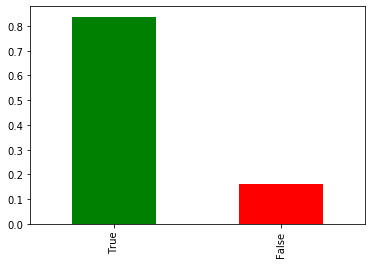

In [50]:
df_launch_fs['launch_success'].value_counts(normalize=True).plot(kind='bar', color=['g','r'])

In [51]:
df_launch_fs['launch_date_utc']

0   2006-03-24 22:30:00+00:00
0   2007-03-21 01:10:00+00:00
0   2008-08-02 03:34:00+00:00
0   2008-09-28 23:15:00+00:00
0   2009-07-13 03:35:00+00:00
               ...           
0   2020-01-01 00:00:00+00:00
0   2020-08-30 00:00:00+00:00
0   2020-07-01 00:00:00+00:00
0   2020-07-01 00:00:00+00:00
0   2020-10-20 00:00:00+00:00
Name: launch_date_utc, Length: 105, dtype: datetime64[ns, UTC]

In [52]:
df_launch_fs['launch_date_utc']

0   2006-03-24 22:30:00+00:00
0   2007-03-21 01:10:00+00:00
0   2008-08-02 03:34:00+00:00
0   2008-09-28 23:15:00+00:00
0   2009-07-13 03:35:00+00:00
               ...           
0   2020-01-01 00:00:00+00:00
0   2020-08-30 00:00:00+00:00
0   2020-07-01 00:00:00+00:00
0   2020-07-01 00:00:00+00:00
0   2020-10-20 00:00:00+00:00
Name: launch_date_utc, Length: 105, dtype: datetime64[ns, UTC]

In [53]:
df_launch_group = df_launch_fs.groupby('launch_date_utc').agg('count')

df_launch_group

,flight_number,mission_name,mission_id,upcoming,launch_year,launch_date_unix,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,ships,launch_success,details,static_fire_date_utc,static_fire_date_unix,rocket.rocket_id,rocket.rocket_name,rocket.rocket_type,rocket.first_stage.cores,rocket.second_stage.block,rocket.second_stage.payloads,rocket.fairings.reused,rocket.fairings.recovery_attempt,rocket.fairings.recovered,launch_site.site_id,launch_site.site_name,launch_site.site_name_long,links.mission_patch,links.mission_patch_small,links.reddit_campaign,links.reddit_launch,links.reddit_media,links.presskit,links.article_link,links.wikipedia,links.video_link,links.youtube_id,links.flickr_images,timeline.webcast_liftoff,timeline.go_for_prop_loading,timeline.rp1_loading,timeline.stage1_lox_loading,timeline.stage2_lox_loading,timeline.engine_chill,timeline.prelaunch_checks,timeline.propellant_pressurization,timeline.go_for_launch,timeline.ignition,timeline.liftoff,timeline.maxq,timeline.meco,timeline.stage_sep,timeline.second_stage_ignition,timeline.seco-1
launch_date_utc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-03-24 22:30:00+00:00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2007-03-21 01:10:00+00:00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2008-08-02 03:34:00+00:00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2008-09-28 23:15:00+00:00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2009-07-13 03:35:00+00:00,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-01 00:00:00+00:00,2,2,2,2,2,2,2,2,2,2,0,2,2,0,0,0,2,2,2,2,2,2,0,0,0,2,2,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-08-01 00:00:00+00:00,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2020-08-02 00:00:00+00:00,1,1,1,1,1,1,1,1,1,1,0,1,1,0,0,0,1,1,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


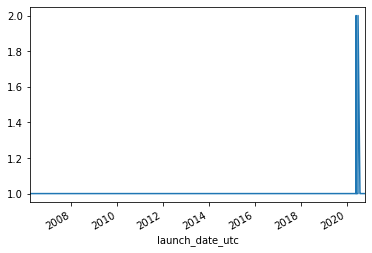

In [54]:
df_launch_group['flight_number'].plot()

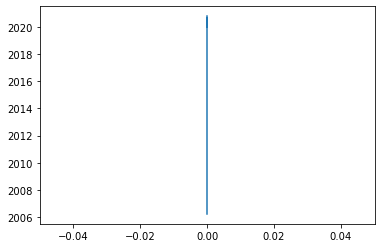

In [55]:
df_launch_fs['launch_date_utc'].plot()

In [56]:
# for column in df_launch_fs.select_dtypes('object'):
# #     print(f'{column:-<70} {df_launch_fs[column].unique()}')

In [57]:
Launch_related = pd.Series(
['launch_year', 
'launch_date_unix', 
'launch_date_utc',
'crew', 
'ships', 
'launch_success',
'details', 
'launch_site.site_id', 
'launch_site.site_name', 
'launch_site.site_name_long', 
'launch_failure_details.time', 
'launch_failure_details.altitude', 
'launch_failure_details.reason'])

launch = pd.DataFrame(Launch_related)
launch

,0
0,launch_year
1,launch_date_unix
2,launch_date_utc
3,crew
4,ships
5,launch_success
6,details
7,launch_site.site_id
8,launch_site.site_name
9,launch_site.site_name_long


In [60]:
spacex_data

,flight_number,mission_name,upcoming,launch_year,launch_date_unix,launch_date_utc,launch_date_local,is_tentative,tentative_max_precision,tbd,launch_window,rocket_rocket_id,rocket_rocket_name,rocket_rocket_type,rocket_first_stage_cores_0_core_serial,rocket_first_stage_cores_0_flight,rocket_first_stage_cores_0_block,rocket_first_stage_cores_0_gridfins,rocket_first_stage_cores_0_legs,rocket_first_stage_cores_0_reused,rocket_first_stage_cores_0_landing_intent,rocket_second_stage_block,rocket_second_stage_payloads_0_payload_id,rocket_second_stage_payloads_0_reused,rocket_second_stage_payloads_0_customers_0,rocket_second_stage_payloads_0_nationality,rocket_second_stage_payloads_0_manufacturer,rocket_second_stage_payloads_0_payload_type,rocket_second_stage_payloads_0_payload_mass_kg,rocket_second_stage_payloads_0_payload_mass_lbs,rocket_second_stage_payloads_0_orbit,rocket_second_stage_payloads_0_orbit_params_reference_system,rocket_second_stage_payloads_0_orbit_params_regime,rocket_second_stage_payloads_0_orbit_params_semi_major_axis_km,rocket_second_stage_payloads_0_orbit_params_eccentricity,rocket_second_stage_payloads_0_orbit_params_periapsis_km,rocket_second_stage_payloads_0_orbit_params_apoapsis_km,rocket_second_stage_payloads_0_orbit_params_inclination_deg,rocket_second_stage_payloads_0_orbit_params_period_min,rocket_second_stage_payloads_0_orbit_params_epoch,rocket_second_stage_payloads_0_orbit_params_mean_motion,rocket_second_stage_payloads_0_orbit_params_raan,rocket_second_stage_payloads_0_orbit_params_arg_of_pericenter,rocket_second_stage_payloads_0_orbit_params_mean_anomaly,launch_site_site_id,launch_site_site_name,launch_site_site_name_long,launch_success,details,static_fire_date_utc,static_fire_date_unix,timeline_webcast_liftoff,rocket_second_stage_payloads_0_norad_id_0,timeline_go_for_prop_loading,timeline_stage1_lox_loading,timeline_stage2_lox_loading,timeline_engine_chill,timeline_prelaunch_checks,timeline_propellant_pressurization,timeline_go_for_launch,timeline_ignition,timeline_liftoff,timeline_second_stage_ignition,launch_date,launch_time
0,1,FalconSat,False,2006,1143239400,2006-03-24 17:30:00-05:00,2006-03-25T10:30:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin A,Merlin1A,1.0,NaN,False,False,False,False,1.0,FalconSAT-2,False,DARPA,United States,SSTL,Satellite,20.0,43.000,LEO,geocentric,low-earth,NaN,NaN,400.000,500.000,39.0000,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,Engine failure at 33 seconds and loss of vehicle,2006-03-17T00:00:00.000Z,1.142554e+09,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-03-24,17:30:00
1,2,DemoSat,False,2007,1174439400,2007-03-20 21:10:00-04:00,2007-03-21T13:10:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin A,Merlin2A,1.0,NaN,False,False,False,False,1.0,DemoSAT,False,DARPA,United States,SpaceX,Satellite,NaN,NaN,LEO,geocentric,low-earth,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,Successful first stage burn and transition to ...,None,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-03-20,21:10:00
2,3,Trailblazer,False,2008,1217648040,2008-08-01 23:34:00-04:00,2008-08-02T15:34:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin C,Merlin1C,1.0,NaN,False,False,False,False,1.0,Trailblazer,False,NASA,United States,Space Dev,Satellite,NaN,NaN,LEO,geocentric,low-earth,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,kwajalein_atoll,Kwajalein Atoll,Kwajalein Atoll Omelek Island,False,Residual stage 1 thrust led to collision betwe...,None,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-08-01,23:34:00
3,4,RatSat,False,2008,1222643700,2008-09-28 19:15:00-04:00,2008-09-28T11:15:00+12:00,False,hour,False,0.0,falcon1,Falcon 1,Merlin C,Merlin2C,1.0,NaN,False,False,False,False,1.0,RatSat,False,SpaceX,United States,SpaceX,Satellite,165.0,363.000,LEO,geocentric,low-earth,6992.251,0.001269,605.243,622.989,9.3467,96.980,2020-05-26T16:23:34.000Z,14.8

In [66]:
spacex_data['launch_date_utc'].asfreq(freq='m')

Series([], Freq: M, Name: launch_date_utc, dtype: datetime64[ns, US/Eastern])

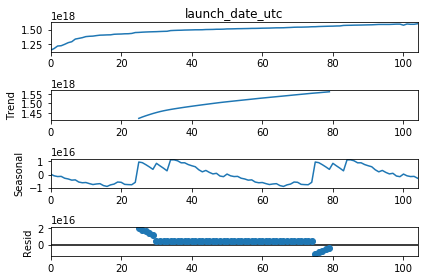

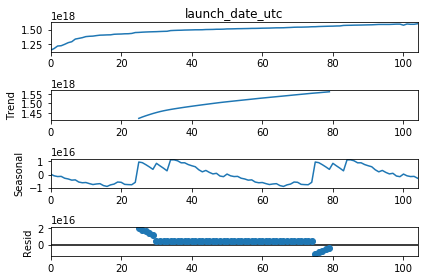

In [86]:
seasonality = sm.tsa.seasonal_decompose(spacex_data['launch_date_utc'], period=50)

seasonality.plot()

In [87]:
# space2 = spacex_data.set_index('launch_date_local')

In [88]:
# seasonality = sm.tsa.seasonal_decompose(space2.index, freq=None)

# seasonality.plot()

In [76]:
space2.index

DatetimeIndex(['2006-03-24 17:30:00-05:00', '2007-03-20 21:10:00-04:00',
               '2008-08-01 23:34:00-04:00', '2008-09-28 19:15:00-04:00',
               '2009-07-12 23:35:00-04:00', '2010-06-04 14:45:00-04:00',
               '2010-12-08 10:43:00-05:00', '2012-05-22 03:44:00-04:00',
               '2012-10-07 20:35:00-04:00', '2013-03-01 14:10:00-05:00',
               ...
               '2020-05-31 20:00:00-04:00', '2020-05-31 20:00:00-04:00',
               '2020-06-29 20:00:00-04:00', '2020-08-01 20:00:00-04:00',
               '2020-07-31 20:00:00-04:00', '2019-12-31 19:00:00-05:00',
               '2020-08-29 20:00:00-04:00', '2020-06-30 20:00:00-04:00',
               '2020-06-30 20:00:00-04:00', '2020-10-19 20:00:00-04:00'],
              dtype='datetime64[ns, US/Eastern]', name='launch_date_utc', length=105, freq=None)